## Segment Anything Model (SAM) - DIFFRACTION(ceta): live workflow
- Acquire an image using HAADF detector
- Feed HAADF image in SAM pipeline:
        - get particles with segmented masks
        - find center point of each particle
- Acquire diffraction(ceta) detector signals at center of each particle
#### Contributor(s): Utkarsh Pratiush <utkarshp1161@gmail.com> - 31st March 2025
#### edited - 
   

In [1]:
from stemOrchestrator.logging_config   import setup_logging
data_folder  = "."
out_path = data_folder
setup_logging(out_path=out_path) 

In [2]:
from stemOrchestrator.acquisition import TFacquisition, DMacquisition
from stemOrchestrator.simulation import DMtwin
from stemOrchestrator.process import HAADF_tiff_to_png, tiff_to_png
from autoscript_tem_microscope_client import TemMicroscopeClient
import matplotlib.pyplot as plt
import logging
from typing import Dict
import os

In [3]:
########SAM part ********************************************************************************************************

from stemOrchestrator.MLlayer.MLlayerSAM import setup_device, download_sam_model, initialize_sam_model, preprocess_image, generate_and_save_masks, create_normalized_particle_positions, display_image_with_masks, display_image_with_labels, extract_mask_contours, generate_mask_colors, visualize_masks_with_boundaries, extract_particle_data, print_boundary_points_info, plot_centroids, sample_particle_positions, plot_sampled_positions, create_visualization_with_masks
import pickle
import numpy as np
from numpy.typing import NDArray 
from typing import List, Dict, Union


def run_sam(image_data: np.ndarray, path_folder: str) -> Union[List, Dict]:
    """Main function to run SAM segmentation pipeline."""
    device = setup_device()
    
    model_type = "vit_b"  # Options: 'vit_b', 'vit_l', 'vit_h'
    checkpoint_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
    checkpoint_path = "sam_vit_b_01ec64.pth"
    download_sam_model(model_type, checkpoint_url, checkpoint_path)
    sam, mask_generator = initialize_sam_model(model_type, checkpoint_path, device)
    img_np = preprocess_image(image_data)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_np)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    # Generate and visualize masks
    masks_path = f'{path_folder}/masks_Au_online.pkl'
    masks = generate_and_save_masks(mask_generator, img_np, masks_path)
    visual_image, centroids = create_visualization_with_masks(img_np, masks)
    display_image_with_masks(visual_image, "Image with Segmentation Masks")
    display_image_with_labels(visual_image, centroids, "Image with Segmentation Masks and Labels")
    
    mask_contours = extract_mask_contours(masks)
    mask_colors = generate_mask_colors(len(masks))
    boundaries_path = f"{path_folder}/Segmentation Masks with Boundaries and Centroids.png"
    visualize_masks_with_boundaries(visual_image, centroids, mask_contours, mask_colors, boundaries_path)
    particles = extract_particle_data(masks)
    # Save particle data
    with open(f'{path_folder}/particles.pkl', 'wb') as f:
        pickle.dump(particles, f)
    
    print_boundary_points_info(particles)
    centroids_array = np.array(centroids)
    plot_centroids(centroids_array, img_np)
    positions_sampled = sample_particle_positions(particles, img_np)
    plot_sampled_positions(positions_sampled, img_np, len(centroids))
    each_particle_position = create_normalized_particle_positions(particles, img_np.shape[:2])
    with open(f'{path_folder}/sampled_boundary_pts_particles.pkl', 'wb') as f: # Save normalized particle positions
        pickle.dump(each_particle_position, f)
    
    all_particle_keys = each_particle_position.keys()


    
    print("Processing complete!")
    return all_particle_keys, each_particle_position

##########****************************************************************************************************************************


In [4]:
def main(config :Dict) -> None:
    ip = config["ip"]
    port = config["port"]
    haadf_exposure = config["haadf_exposure"]
    haadf_resolution = config["haadf_resolution"]
    out_path = config["out_path"]
    setup_logging(out_path=out_path)
    

    microscope_tf = TemMicroscopeClient()
    microscope_tf.connect(ip, port = port)# 7521 on velox  computer
    microscope_dm = DMtwin()
    # query state:

    global tf_acquisition
    tf_acquisition = TFacquisition(microscope=microscope_tf, offline=True)
    # dm_acquisition = DMacquisition(microscope=microscope_dm, offline=True)

    # Get haadf
    haadf_np_array, haadf_tiff_name = tf_acquisition.acquire_haadf(exposure = haadf_exposure, resolution=haadf_resolution)
    tf_acquisition.haadf_det.retract()    
    HAADF_tiff_to_png(haadf_tiff_name)
    logging.info("END acquisition.")
    
    all_particle_keys, each_particle_position = run_sam(haadf_np_array, out_path)
    
    
    def acquire_and_plot_combined(image_data, particle_key, ceta_exposure):
        """Acquire EDS spectrum, CETA image, and plot all three components in a single figure."""
        
        
        # lets do just eels at boundary points
        print(f"cbed at centres for particle{particle_key}")
        # Ensure the directory exists
        directory = f'{out_path}/particle{particle_key}'
        if not os.path.exists(directory):
            os.makedirs(directory)
        # Acquire the CETA image
        # ceta_cam.insert()
        wait_sec = 2
        # print(f"ceta-wait insert{wait_sec} sec")
        # time.sleep(wait_sec)
        ceta_cp_array, ceta_tiff_name = tf_acquisition.acquire_ceta_or_flucam(exposure=ceta_exposure, resolution=1024, camera="ceta")
        tiff_to_png(ceta_tiff_name)
        

        # clip the bright spots
        shifted_data = ceta_cp_array
        p99 = np.percentile(shifted_data.ravel(), 99)
        clipped_data = np.clip(shifted_data, 0, p99)
        clipped_data -= clipped_data.min()
        clipped_data /= clipped_data.max()
        norm_data = clipped_data
        # power law 2nd time through
        gamma = 1
        norm_data = norm_data ** gamma
        edge_crop = 256
        norm_data = norm_data[edge_crop:-edge_crop, edge_crop:-edge_crop]
        
        
        # img = ceta_cp_array - np.min(ceta_cp_array)
        # ceta_image_data = (255 * (img / np.max(img))).astype(np.uint8)
        # n = ceta_image_data.shape[0]# 4096
        # # center_half = ceta_image_data[n // 4: 3 * n // 4, n // 4: 3 * n // 4]
        # # center_quarter = ceta_image_data[n // 2: 3 * n // 4, n // 2: 3 * n // 4]
        # center_quarter = ceta_image_data[1024:-1024, 1024:-1024]
        
        # Get the current beam position
        position = tf_acquisition.query_paused_beam_positon()
        x = position.x
        y = position.y
        formatted_position = f"({x:.2g}, {y:.2g})"

        # Create a figure with three subplots
        fig, axs = plt.subplots(1, 2, figsize=(18, 6))

        # Plot the acquired image data
        axs[0].imshow(image_data, cmap='gray')
        axs[0].set_title('Acquired Image')
        axs[0].set_axis_off()  # Hide axes for the image plot
        axs[0].scatter(x * image_data.shape[0], y * image_data.shape[1], c='r', s=100, marker='x', label=f"Position: {formatted_position}")
        axs[1].imshow((norm_data), cmap='gray')  # Using log contrast
        # axs[1].imshow(np.log(center_quarter + 1), cmap='gray')  # Using log contrast
        axs[1].set_title(f'Acquired CETA Image at Position: {formatted_position}')
        axs[1].set_axis_off()  # Hide axes for the image plot


        # Adjust layout and display
        plt.tight_layout()
        plt.savefig(f'{out_path}/particle{particle_key}/haadf_cbed_at_centroid of particle{particle_key}_{formatted_position}.png', dpi = 300)
        plt.close()


        # save the ceta and spectrum data
        np.save(f'{out_path}/particle{particle_key}/ceta image at position {formatted_position}.npy', norm_data)# ceta image save
        # ceta_image.save(f'{out_path}/ceta_raw_ at position {formatted_position}.tiff')




    def run_acquisition_for_particle(image_data, particle_key, particle_dict, ceta_exposure):
        """Run the entire acquisition process for a given position."""
        position = list(particle_dict[particle_key]["centroid"])
        tf_acquisition.move_paused_beam(position[0], position[1])
        acquire_and_plot_combined(image_data, particle_key, ceta_exposure)


    spec_metadata_dict = {"ceta_exposure_sec" : 0.1}

    ceta_exposure = spec_metadata_dict["ceta_exposure_sec"]

    file_path = f'{out_path}/spectrometer_metadata_dict.pkl'
    # Save the dictionary to disk
    with open(file_path, 'wb') as file:
        pickle.dump(spec_metadata_dict, file)
    print(f"spectrometer_metadata_dictsaved to {file_path}")

    for particle_key in all_particle_keys:
        run_acquisition_for_particle(haadf_np_array,particle_key, each_particle_position, ceta_exposure)# 25 seconds per reading: --> 1min 35 seconds for 4 points

    

## Connect to the microscope

Client connecting to [10.46.217.241:9095]...
Client connected to [10.46.217.241:9095]
Starting microscope initialization...
CETA camera initialized
HAADF detector initialized
Microscope initialization completed successfully
Acquiring HAADF image.
saving HAADF image as TF which has all the metadata..also returning an array
Done: Acquiring HAADF image - beam is blanked after acquisition - HAADF det is inserted


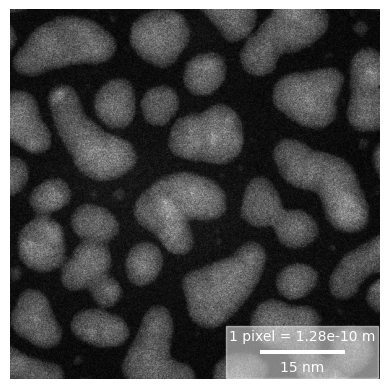

END acquisition.
Using device: cpu
SAM model checkpoint already exists.


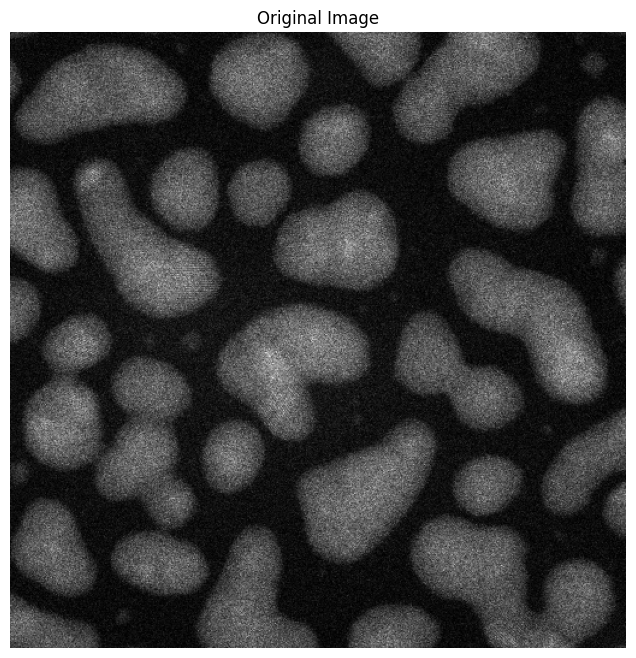

Generating masks...
Number of masks generated: 45


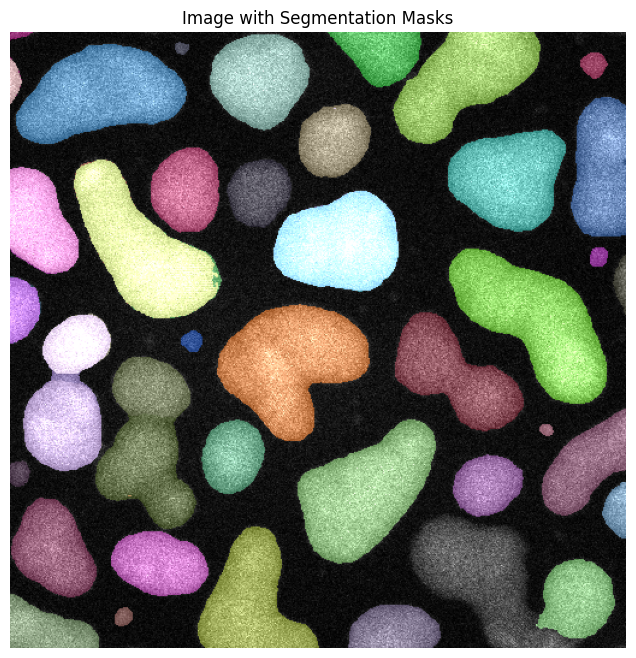

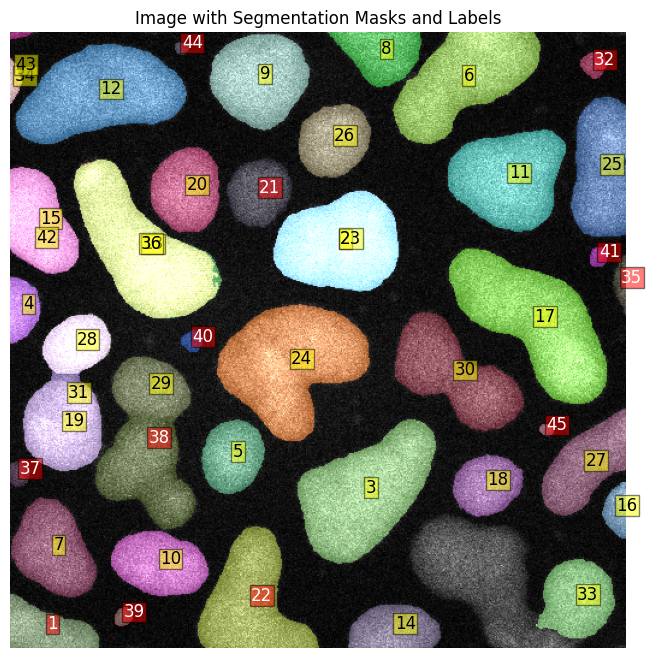

Extracted contours for 45 masks.
Total particles stored: 45
Boundary Points per Particle:
-----------------------------
Particle 1: 6 boundary points
Particle 2: 12 boundary points
Particle 3: 12 boundary points
Particle 4: 8 boundary points
Particle 5: 12 boundary points
Particle 6: 12 boundary points
Particle 7: 11 boundary points
Particle 8: 6 boundary points
Particle 9: 11 boundary points
Particle 10: 11 boundary points
Particle 11: 8 boundary points
Particle 12: 11 boundary points
Particle 13: 12 boundary points
Particle 14: 8 boundary points
Particle 15: 9 boundary points
Particle 16: 9 boundary points
Particle 17: 11 boundary points
Particle 18: 11 boundary points
Particle 19: 11 boundary points
Particle 20: 12 boundary points
Particle 21: 12 boundary points
Particle 22: 11 boundary points
Particle 23: 12 boundary points
Particle 24: 13 boundary points
Particle 25: 8 boundary points
Particle 26: 10 boundary points
Particle 27: 10 boundary points
Particle 28: 10 boundary points
P

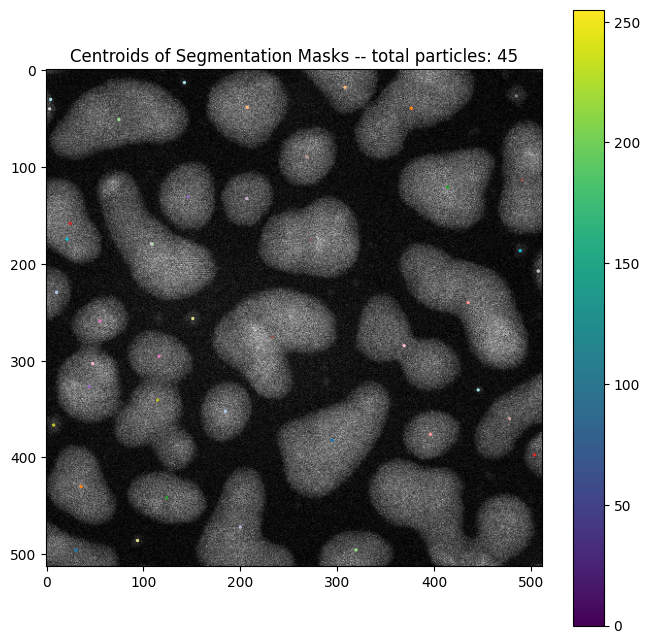

Positions array shape: (526, 3)


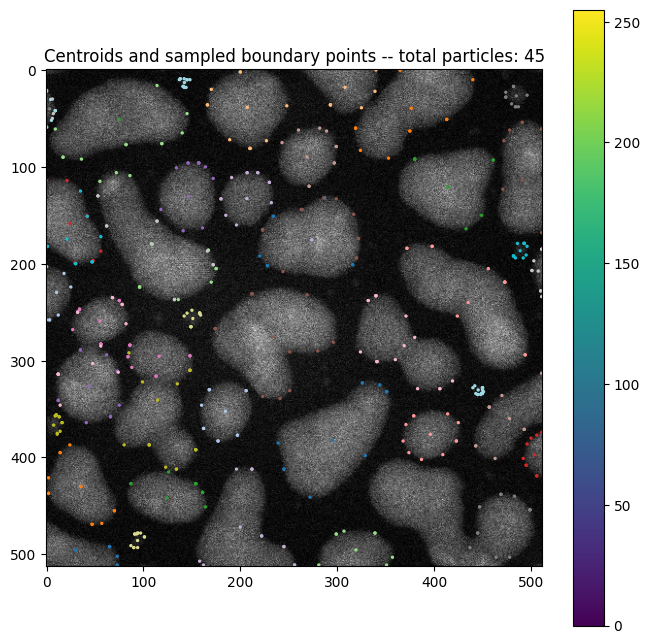

Processing complete!
spectrometer_metadata_dictsaved to ./spectrometer_metadata_dict.pkl
Set beam position: old Point(x=1, y=1)
UPDATED beam position: NewPoint(x=0.058936708, y=0.96810865)
cbed at centres for particle1


ApplicationServerException: An unexpected error occurred in the application server.
The insert operation is not allowed in Unknown state.

In [5]:
import os
import json
from pathlib import Path

ip = os.getenv("MICROSCOPE_IP")
port = os.getenv("MICROSCOPE_PORT")

if not ip or not port:
    secret_path = Path("../../config_secret.json")
    if secret_path.exists():
        with open(secret_path, "r") as f:
            secret = json.load(f)
            ip = ip or secret.get("ip_TF")
            port = port or secret.get("port_TF")


if not ip:
    ip = input("Enter microscope IP: ")
if not port:
    port = input("Enter microscope Port: ")

try:
    port = int(port)
except ValueError:
    raise ValueError("Port must be an integer")

config = {
    "ip": ip,
    "port": port,
    "haadf_exposure": 10e-6,  # micro-seconds per pixel
    "haadf_resolution": 512, # square
    "out_path": "."
}

main(config=config)
